In [1]:
import numpy as np
import math, copy
from matplotlib import pyplot as plt
from matplotlib import gridspec
from shapely.geometry import LineString

from local_utils import dst_bearing, rl_inverse, draw, intersect, rad_magic, rad_back_magic

In [2]:
class ShiftedLogCurve(): 

    def __init__(self, a=1, b=1, root=(0,0), leaf=(0,20), vbs = False, run=False):
        '''
        КОНСТРУКТОР
        Инициализирует параметры кривой. Переводит координаты корня и листа в полярные координаты
        a: радиус кривизны
        b: производная
        root: координаты корня
        leaf: координаты листа
        vbs: verbose output? True/False
        run: Если True, запускаются функции eval и кривая строится после инициализации (определяются координаты точек)
        
        self.th: область определения функции (диапазон параметра t)
        '''
        self.a = a # Радиус кривизны
        self.b = b # Производная
        self.th = np.linspace(0, np.pi, 100) # Область определения в полярных координатах (угол в радианах)
        self.root = root # Координаты корня
        self.leaf = leaf # Координаты листа
        self.vbs = vbs # verbose?
        self.run = run # run?
        self.ang = None # Дирекционный угол в радианах (против часовой стрелки от оси x)
        self.dst = None # Расстояние между корнем и листом

        self._pts_to_polar()
        
        self.crds = None # Прямоугольные координаты
        self.r = None # Массив r(th) радиусов в полярных координатах
        if run:
            self.eval_a()
            self._eval_r(self.th)
            self.proj_rect()
        
    
    def _pts_to_polar(self):
        '''
        ПЕРЕВОД В ПОЛЯРНЫЕ КООРДИНАТЫ (0° вправо, отсчёт против часовой стрелки)
        Для построения кривой между корнем и листом необходимо подобрать параметр a при фиксированном b.
        Для этого в данной реализации необходимо знать расстояние от корня до листа.
        Азимут нужен для обратного перевода кривой в прямоугольные координаты
        
        формат координат: (ось абсцисс, ось ординат)
        
        return не предусмотрен.
        Модифицируются:
        self.ang: азимут
        self.dst: расстояние
        '''
        dx = self.leaf[0] - self.root[0]
        dy = self.leaf[1] - self.root[1]
        if self.vbs: print("dx: ", dx, "dy: ", dy)
        try:
            self.ang = np.arctan2(dy, dx)
        except ZeroDivisionError:
            self.ang = -np.pi/2 # Ловим деление на 0 при dx = 0
        if self.vbs: print("angle: ", np.degrees(self.ang))
        self.dst = np.sqrt(dx**2 + dy**2)
        if self.vbs: print("distance: ", self.dst)
    
    def _eval_r(self, th):
        '''
        ОПРЕДЕЛЕНИЕ ЗНАЧЕНИЙ РАДИУСА ДЛЯ ОБЛАСТИ ОПРЕДЕЛЕНИЙ (углов)
        Экспонента сдвинута на -1.
        Таким образом область значений сдвигается на -self.a относительно лог. спирали по определению
        Это необходио, чтобы область значений начиналась от 0
        th: np.array область определения (массив углов для котрых требуется рассчитать радиус)
        
        return: np.array значения функции в полярных координатах
        '''
        self.r = self.a*(np.exp(self.b*th)-1)
        return self.a*(np.exp(self.b*th)-1)
    
    def proj_rect(self, r=None):
        '''
        ПЕРЕВОД В ПРЯМОУГОЛЬНЫЕ КООРДИНАТЫ
        Функция переводит кривую в полярных координатах (массив R(th) для массива th) в прямоугольные (массив x и массив y)
        Результат: редактирование атрибута self.crds

        input: обязательных аргументов нет
        R: массив R(th). Если None, то используется self.R

        return: self.crds (на всякий случай)
        '''
        if r is None:
            r = self.r
        thr = self.th + self.ang + np.pi
        thl = -self.th + self.ang + np.pi
        xr = r*np.cos(thr)
        yr = r*np.sin(thr)
        xl = r*np.cos(thl)
        yl = r*np.sin(thl)
        self.crds = {"right_xy": [xr, yr], "left_xy": [xl, yl]}
        return self.crds
    
    def eval_r(self, th=None, run=False):
        '''
        ОПРЕДЕЛЕНИЕ ЗНАЧЕНИЙ РАДИУСА ДЛЯ ОБЛАСТИ ОПРЕДЕЛЕНИЙ (углов)
        Функция вызова
        Вызывает _eval_r с заданной областью определения (th).
        Если область не задана, используется инициализированная ([0, np.pi])
        
        th: np.array
        run: Если True, то объект подлежит изменению. Если False, то объект не будет изменён

        return: np.array значения функции в полярных координатах
        
        '''
        if (th is None) and run:
            return self._eval_r(self.th)
        elif not(th is None) and run:
            return self._eval_r(th)
        elif th is None:
            return self.a*(np.exp(self.b*self.th)-1)
        else:
            return self.a*(np.exp(self.b*th)-1)

    def eval_a(self):
        '''
        РАСЧЁТ self.a
        Рассчитывает параметр a, который нужно использовать, чтобы "вписать" кривую с заданным b
        между корнем и листом
        Экспонента сдвинута на -1
        
        Входных параметров и return не предусмотрено
        '''
        self.a = self.dst/(np.exp(self.b*np.pi)-1)
    
    def draw(self):
        # Отрисовка кривой внутри области определения
        fig = plt.figure(1,(15,15))
        ax1 = fig.add_subplot(221,polar=True) # раскомментировать эту строку и "222" для отображения в полярных координатах
        ax2 = fig.add_subplot(222,polar=False)
        
        xr,yr = self.proj_rect()["right_xy"]
        xl,yl = self.proj_rect()["left_xy"]
        ax1.plot(self.th, self.r, "-c")
        ax1.plot(-self.th, self.r, "-m")
        ax2.plot(xr,yr, "-c")
        ax2.plot(xl,yl, "-m")
        ax2.plot(self.leaf[0], self.leaf[1], "og")
        ax2.plot(self.root[0], self.root[1], "sg")
        ax2.set_aspect(1)
    
    # Геттеры

    def get_polar(self, tp="right"):
        """
        tp = "right"/"left" (тип спирали: правая или левая)
        """
        if tp == "right":
            return (self.th, self.r)
        elif tp == "left":
            return (-self.th, self.r)
        else:
            raise ValueError('tp has to be "right" or "left"')
    
    def get_rect(self, tp="right"):
        """
        tp = "right"/"left" (тип спирали: правая или левая)
        """
        if tp in ("right", "left"):
            return (self.crds[f"{tp}_xy"][0], self.crds[f"{tp}_xy"][1])
        else:
            raise ValueError('tp has to be "right" or "left"')

            

In [3]:
class LimitedSLC(ShiftedLogCurve):
    '''
    Дополнительные атрибуты:
    tp - тип. Принимает значения 'right' и 'left'
    upperlimit_xy - координаты верхней границы
    lowerlimit_xy - координаты нижней границы

    
    '''

    def draw(self):
        # Отрисовка кривой внутри области определения
        fig = plt.figure(1,(15,15))
        ax1 = fig.add_subplot(221,polar=True) # раскомментировать эту строку и "222" для отображения в полярных координатах
        ax2 = fig.add_subplot(222,polar=False)
        
        x,y = self.proj_rect()[f"{self.tp}_xy"]
        
        if self.tp == 'right':
            sign = -1
            color = 'c'
        else:
            sign =1
            color = 'm'

        ax1.plot(self.th*sign, self.r, f"-{color}")
        
        ax2.plot(x,y, f"-{color}")


        ax2.plot(self.lowerlimit_xy[0], self.lowerlimit_xy[1], "^k")
        ax2.plot(self.upperlimit_xy[0], self.upperlimit_xy[1], "vk")

        ax2.plot(self.leaf[0], self.leaf[1], "og")
        ax2.plot(self.root[0], self.root[1], "sg")

        ax2.set_aspect(1)
    
    def batch_draw(self, ax1, ax2):
        # Добавление кривой на передаваемый график
        
        x,y = self.proj_rect()[f"{self.tp}_xy"]
        
        if self.tp == 'right':
            sign = -1
            color = 'c'
        else:
            sign =1
            color = 'm'

        ax1.plot(self.th*sign, self.r, f"-{color}")
        
        ax2.plot(x,y, f"-{color}")
        ax2.plot(self.lowerlimit_xy[0], self.lowerlimit_xy[1], "^k")
        ax2.plot(self.upperlimit_xy[0], self.upperlimit_xy[1], "vk")
        ax2.plot(self.leaf[0], self.leaf[1], "og")
        ax2.plot(self.root[0], self.root[1], "sg")
        ax2.set_aspect(1)
    

    def crop(self, tp, upperlimit_xy=None, lowerlimit_xy=None):
        '''
        Вырезание кривой между точками
        '''
        # Проверки и определения
        assert tp in ('right', 'left'), "tp must be assigned"

        self.tp = tp
        self.upperlimit_xy = upperlimit_xy
        self.lowerlimit_xy = lowerlimit_xy

        upperlimit_th = lowerlimit_th = None

        if upperlimit_xy is None:
            self.upperlimit_xy = self.leaf
            upperlimit_th = np.pi
        if lowerlimit_xy is None:
            self.lowerlimit_xy = self.root
            lowerlimit_th = 0
        
        # Расчет
        if tp == 'right': sign = 1
        else: sign = -1

        if upperlimit_th is None:
            uplt_th_ang = np.arctan2(upperlimit_xy[1]-self.root[1], upperlimit_xy[0]-self.root[0])

            # this if statement handles situation, when intersection is above zero and leaf is below zero
            # withput this statemnt ~limit_th calculation is incorrect
            if np.sign(uplt_th_ang) == -1 and np.sign(self.ang) == 1:
                uplt_th_ang = rad_back_magic(uplt_th_ang)

            upperlimit_th = np.pi - sign*(self.ang - uplt_th_ang)
        if lowerlimit_th is None:
            lwlt_th_ang = np.arctan2(lowerlimit_xy[1]-self.root[1], lowerlimit_xy[0]-self.root[0])

            # this if statement handles situation, when intersection is above zero and leaf is below zero
            # withput this statemnt ~limit_th calculation is incorrect
            if np.sign(lwlt_th_ang) == -1 and np.sign(self.ang) == 1:
                lwlt_th_ang = rad_back_magic(lwlt_th_ang)

            lowerlimit_th = np.pi - sign*(self.ang - lwlt_th_ang)

        # Запись результата
        self.th = np.linspace(lowerlimit_th, upperlimit_th, 100)
        # Перевычисление радиусов для новых th
        self.eval_r(run=True)
        
    def get_dst2(self):
        try:
            return np.sqrt((self.upperlimit_xy[0]-self.lowerlimit_xy[0])**2 + (self.upperlimit_xy[1]-self.lowerlimit_xy[1])**2)
        except AttributeError:
            return self.dst

In [48]:
class NodeRegion():

    def __init__(self, root=None, leaf=None, th=None, crds=None):
        """Constructor
        """
        self.root = (0,0) if root is None else root
        self.leaf = (0,0) if leaf is None else leaf

        self.dst, self.ang = dst_bearing(self.root, self.leaf)
        self.th = np.linspace(0, np.pi, 100) if th is None else th
        self.crds = {"right_xy": (0,0), "left_xy": (0,0)} if crds is None else crds
        self.validate_crds(crds)

    def validate_crds(crds):
        """if crds.keys() are not 'right_xy' or 'left_xy', raises KeyError
        if any of crds.values() is not sequence, raises TypeError
        """
        if not all(list(map(lambda x: x == 'right_xy' or x == 'left_xy', list(crds.keys())))) == True:
            raise KeyError(f"{crds.keys()} are invalid keys. Keys must be ('right_xy', 'left_xy')")
        
        if not all(list(map(lambda x: type(x) in (tuple, list), crds.values()))) == True:
            raise TypeError(f"{crds.values()} are invalid values. Coordinates must be tuples or lists")



In [55]:
class FlowTree():

    def __init__(self, root=None, leaves=None):
        self.root = (0,0) if root is None else root
        self.leaves = [ (17, -4), (20, 7), (-10, 15), (-5, 20), (-8, -20)] if leaves is None else leaves

    def build():
        pass
    
    def draw():
        pass
    
    def to_geometry_query():
        pass

In [71]:
class FlowTreeBuilder():

    def __init__(self, root=(0,0), leaves=[ (17, -4), (20, 7), (-10, 15), (-5, 20), (-8, -20)], b=1.9, vbs=False):
        self.root = root
        self.leaves = leaves
        self.b = b
        self.vbs = vbs
        self.arcs = self.main_exec2(self.root, self.leaves, self.b)
        
    
    def main_exec(self, root, leaves, b):

        fig = plt.figure(1,(20,10), facecolor='gray')
        spec = gridspec.GridSpec(ncols=3, nrows=1,
                         width_ratios=[1, 2, 2], wspace=0.5,
                         hspace=0.5)

        ax1 = fig.add_subplot(spec[0],polar=True, facecolor='white')
        ax2 = fig.add_subplot(spec[1],polar=False, facecolor='white')
        ax3 = fig.add_subplot(spec[2],polar=False, facecolor='white')

        init_curves = [LimitedSLC(b=b, root=root, leaf=leaf, run=True) for leaf in leaves]
        
        if self.vbs: print(len(init_curves))

        intersections = []
        croped_curves = []
        
        draw(init_curves, ax2=ax2)

        ax3.set_xlim(ax2.get_xlim())
        ax3.set_ylim(ax2.get_ylim())

        interm = init_curves.copy()
        for curve in init_curves:
            interm.remove(curve)
            for c in interm:
                # NOT HANDLES NONE OUTPUT FROM INTERSECT
                intersections.append(intersect(curve, c, plotting=True, ax=ax2))
        del c, interm
        
        # entry to intersection queue
        intersections = sorted(intersections, key=lambda x: x["dst"], reverse=True)
        if self.vbs:
            for i in intersections:
                print(i["dst"])
            
        if self.vbs: print("\nwelcome to hell\n")
        
        for i in intersections.copy():
            if not i in intersections:
                continue
            # init queue
            if self.vbs: print(f"Intersection dst: {i['dst']}")
            if self.vbs: print(f"Initial type: {i['position_type'][1]}")
            if self.vbs: print(f"i[curves]: {list(map(lambda x: x.get_dst2(), i['curves']))}")
            cropping_queue = sorted(i["curves"], key=lambda x: rad_magic(x.ang), reverse=True)
            #cropping_queue = sorted(i["curves"], key=lambda x: x.get_dst2(), reverse=False)
            if cropping_queue[0] == i["curves"][0]:
                f_type = i["position_type"][1]
            else:
                f_type = rl_inverse(i["position_type"][1])
            if self.vbs: print(f"Changed type: {f_type}")
            # cropping
            
            #if self.vbs: print(f"Stored initial curves: {init_curves}")
            if self.vbs: print(f"Current intersection curves: {i['curves']}, {i['position_type'][1]}")
            if self.vbs: print(f"Cropping queue: {cropping_queue}")
            init_curves.remove(cropping_queue[0])
            
            cropping_queue[0].crop(f_type, lowerlimit_xy=i["position_type"][0])
            cropping_queue[0].batch_draw(ax1, ax3)
            cropping_queue[1].crop(rl_inverse(f_type))
            croped_curves.append(cropping_queue[0])

            for del_intersection in intersections.copy():
                if cropping_queue[0] in del_intersection["curves"]:
                    intersections.remove(del_intersection)
                if cropping_queue[1] == del_intersection["curves"][0]:
                    if f_type == del_intersection["position_type"][1]:
                        intersections.remove(del_intersection)
                elif cropping_queue[1] == del_intersection["curves"][1]:
                    if rl_inverse(f_type) == del_intersection["position_type"][1]:
                        intersections.remove(del_intersection)
            if self.vbs: print(f"Intersections number: {list(map(lambda x: x['dst'], intersections))}")
            if self.vbs: print("\n")


        for curve in init_curves:
            curve.batch_draw(ax1, ax3)

        return croped_curves
    
    def main_exec2(self, root, leaves, b):
        
        fig = plt.figure(1,(20,10), facecolor='gray')
        spec = gridspec.GridSpec(ncols=3, nrows=1,
                         width_ratios=[1, 2, 2], wspace=0.5,
                         hspace=0.5)

        ax1 = fig.add_subplot(spec[0],polar=True, facecolor='white')
        ax2 = fig.add_subplot(spec[1],polar=False, facecolor='white')
        ax3 = fig.add_subplot(spec[2],polar=False, facecolor='white')

        never_activated = [LimitedSLC(b=b, root=root, leaf=leaf, run=True) for leaf in leaves]

        draw(never_activated, ax2=ax2)

        ax3.set_xlim(ax2.get_xlim())
        ax3.set_ylim(ax2.get_ylim())

        active = []
        curves = []

        C = max(list(map(lambda x: x.dst, never_activated)))
        C -= 0.5
        while C > 0:
            # creating queue
            active = list(filter(lambda x: x.get_dst2() > C, never_activated))

            # intersecting
            intersections = []
            interm = active.copy()
            for curve in active:
                interm.remove(curve)
                for c in interm:
                    # NOT HANDLES NONE OUTPUT FROM INTERSECT
                    intersections.append(intersect(curve, c, plotting=True, ax=ax2))
            try:
                del c, interm
            except UnboundLocalError:
                del interm
            
            # filtering intersections
            
            

            C-=0.5
        return


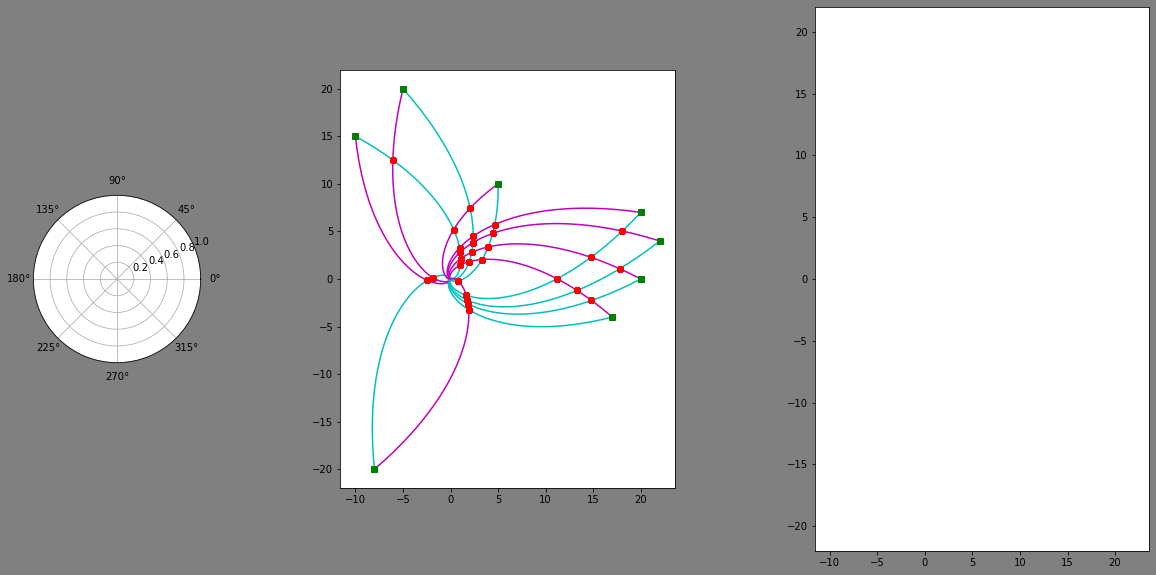

In [72]:
leaves = [ (17, -4), (20, 7), (-10, 15), (-5, 20), (-8, -20), (20, 0), (5, 10), (22, 4)]
expl = FlowTreeBuilder(b=1.9, leaves=leaves, vbs=False)

In [139]:
import random as rand

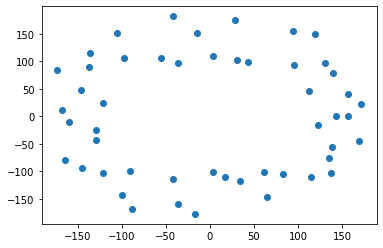

In [10]:
#generate some data
leaves = []

r = 100
phi = np.linspace(0, np.pi*2, 50)
noise = np.random.rand(len(phi))*100
r = r+noise
x = r*np.cos(phi)
y = r*np.sin(phi)
for i in range(len(phi)-1):
    leaves.append((x[i], y[i]))

plt.scatter(x, y)

In [16]:
bias = np.array((193.980769230769, -195.706730769231))
leaves = []
l_prep = [(244.461538461538,-50.7259615384615),
(168.134615384615, -40.2259615384615),
(141.884615384615, -81.4182692307691),
(76.0576923076923, -37.3990384615384),
(216.899038461538, -111.605769230769),
(304.129807692308, -88.8894230769231),
(322.201923076923, -130.6875),
(283.9375, -184.701923076923),
(301.302884615385, -202.471153846154),
(304.9375, -254.971153846154),
(210.841346153846, -279.605769230769),
(185.197115384616, -244.471153846154),
(172.879807692308, -314.538461538462),
(109.879807692308, -310.096153846154),
(46.4759615384617, -278.596153846154),
(59.3990384615386, -214.990384615385),
(114.927884615385, -204.692307692308),
(21.8413461538463, -177.432692307692),
(36.5817307692309, -130.586538461539),
(56.3701923076924, -102.317307692308)]

for i in l_prep:
    leaves.append(list(np.array(i) - bias))

In [27]:
# leaves = [ (17, -4), (20, 7), (-10, 15), (-5, 20), (-8, -20), (20, 0), (5, 10), (22, 4)]
leaves = dataset
# leaves = [ (10, 8), (11, 3), (12, 1), (10.5, -3.5), (11.8, -6)]
expl = FlowTreeBuilder(b=1.9, leaves=leaves, vbs=False)

AttributeError: 'tuple' object has no attribute 'dst'

In [18]:
dataset = [(110.60289476284164, 0.0),
 (172.66269590402504, 38.00593334790393),
 (160.04780458535853, 74.04599928279603),
 (91.28819245356952, 69.39547975534474),
 (84.53031269794627, 99.51677748032657),
 (60.82883221325307, 114.73534898240658),
 (44.21192450783797, 159.23696070102386),
 (9.237648714392932, 170.37840524965335),
 (-16.7481641066041, 102.15928160389913),
 (-46.50537127325378, 116.71968057336491),
 (-77.27938662754069, 113.97856801033778),
 (-102.55266333593273, 97.14304271129762),
 (-114.95662921751178, 69.16710888299222),
 (-120.8788321280685, 40.72882066269916),
 (-178.2827001181997, 19.38941210325078),
 (-154.36600909848062, -16.788315204785544),
 (-140.3941738848047, -47.30430489420864),
 (-108.0101151223719, -64.98753002750344),
 (-79.36277598624645, -75.17641460041725),
 (-94.59789671726276, -139.5214594105088),
 (-56.48931447500145, -141.77748850964534),
 (-25.11407890334805, -153.18910434475615),
 (7.280803914360199, -134.28652660620753),
 (27.132268556261472, -97.72159954396669),
 (89.91828075688638, -169.60386953296788),
 (72.24816247650075, -85.05711240212986),
 (122.04465697419597, -92.77593623741028),
 (108.45855133932353, -50.1782691458383),
 (140.47334670755347, -30.92052179639243)]

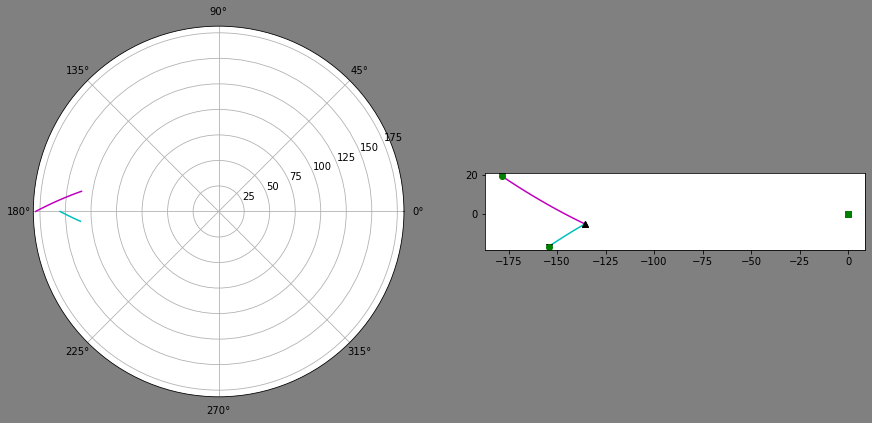

In [27]:
# тест работы LimitedSLC
fig = plt.figure(1,(15,15), facecolor="gray")
ax1 = fig.add_subplot(221,polar=True, facecolor="white")
ax2 = fig.add_subplot(222,polar=False, facecolor="white")

b=1.9
curve = LimitedSLC(b=b, root=(0,0), leaf=(17, -4), run=True)
curve1 = LimitedSLC(b=b, root=(0,0), leaf=(20, 7), run=True)

curve = LimitedSLC(b=b, root=(0,0), leaf=(-10, 15), run=True)
curve1 = LimitedSLC(b=b, root=(0,0), leaf=(-5, 20), run=True)

curve = LimitedSLC(b=b, root=(0,0), leaf=(17, -4), run=True)
curve1 = LimitedSLC(b=b, root=(0,0), leaf=(-8, -20), run=True)

curve = LimitedSLC(b=b, root=(0,0), leaf=(-178.2827001181997, 19.38941210325078), run=True)
curve1 = LimitedSLC(b=b, root=(0,0), leaf=(-154.36600909848062, -16.788315204785544), run=True)

intr = intersect(curve, curve1)['position_type']
point_xy = intr[0]
curve.crop(intr[1],lowerlimit_xy=intr[0])
curve1.crop(rl_inverse(intr[1]),lowerlimit_xy=intr[0])

curve.batch_draw(ax1, ax2)
curve1.batch_draw(ax1, ax2)



In [14]:
np.arctan2(point_xy[1], point_xy[0]) + np.pi*2, curve.ang

(3.1793414035485235, 3.0332618724315243)

{'curves': (<__main__.LimitedSLC at 0x28a458d7640>,
  <__main__.LimitedSLC at 0x28a458d76d0>),
 'position_type': (array([-135.58628037,   -5.12064508]), 'left'),
 'dst': 135.68294081995776}

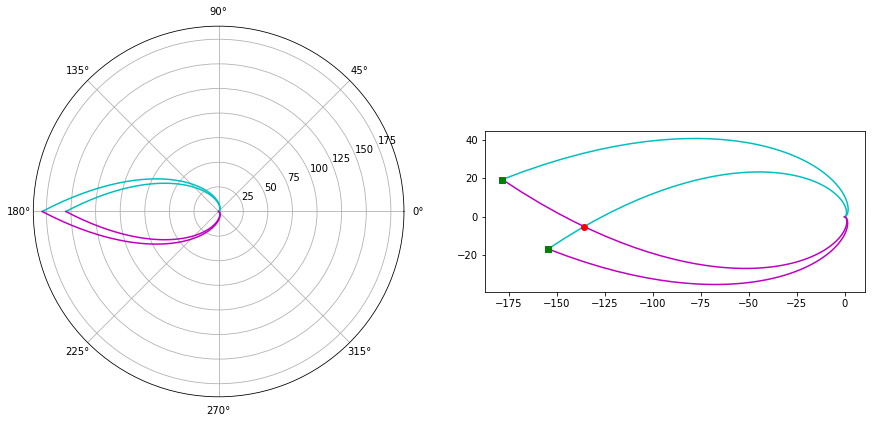

In [230]:
# тес работы intersect на двух кривых
b=1.9
curve = ShiftedLogCurve(b=b, root=(0,0), leaf=(17, -4), run=True)
curve1 = ShiftedLogCurve(b=b, root=(0,0), leaf=(20, 7), run=True)

curve = LimitedSLC(b=b, root=(0,0), leaf=(-178.2827001181997, 19.38941210325078), run=True)
curve1 = LimitedSLC(b=b, root=(0,0), leaf=(-154.36600909848062, -16.788315204785544), run=True)

# Пример отсутствия пересечений:
# curve = ShiftedLogCurve(b=b, root=(0,0), leaf=(-10, 15), run=True)
# curve1 = ShiftedLogCurve(b=b, root=(0,0), leaf=(-5, 5), run=True)

#th_use = np.linspace(0, 10, 100)
#curve.eval_a()
#curve.draw()
draw([curve1, curve])
intersect(curve, curve1, True)

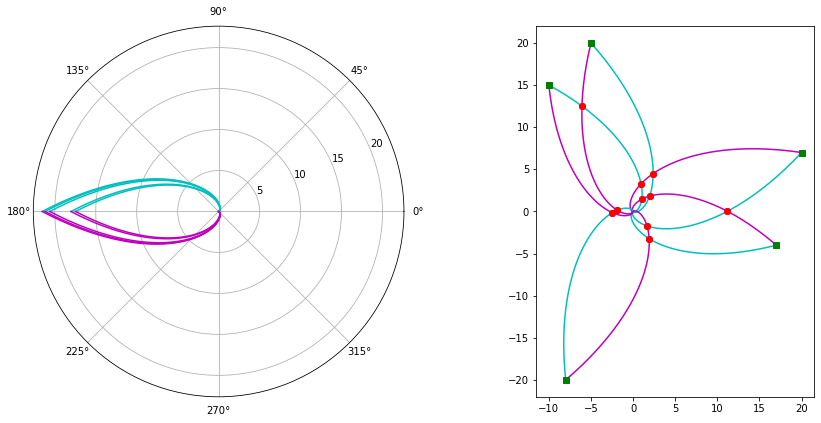

In [6]:
#тест работы intersect и draw на большом наборе
b = 1.9
curves = []
crd_tuple = [ (17, -4), (20, 7), (-10, 15), (-5, 20), (-8, -20)
            # , (3,7)
            ]
for i in crd_tuple:
    curves.append(ShiftedLogCurve(b=b, root=(0,0), leaf=i, run=True))
draw(curves)
for i in curves:
    b = curves.copy()
    b.remove(i)
    for c in b:
        intersect(i, c, plotting=True)['position_type'][0]